In [10]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import keras
from keras import initializers
import tensorflow as tf
from keras import backend as K
from keras.backend import *
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Layer, Lambda, Input, Flatten, Dropout, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, TimeDistributed, ConvLSTM2D, Permute, Reshape, Conv2D
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [11]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [12]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [13]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    print('File Path : ',filepath)
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [14]:
# load all train
X_train, Y_train = load_dataset_group('train', 'UCIDataset/')
# load all test
X_test, Y_test = load_dataset_group('test', 'UCIDataset/')

# zero-offset class values
Y_train = Y_train - 1
Y_test = Y_test - 1
# one hot encode y
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print('X_train.shape : ', X_train.shape)
print('Y_train.shape : ', Y_train.shape)
print('X_test.shape : ', X_test.shape)
print('Y_test.shape : ', Y_test.shape)

File Path :  UCIDataset/train/Inertial Signals/
File Path :  UCIDataset/test/Inertial Signals/
X_train.shape :  (7352, 128, 9)
Y_train.shape :  (7352, 6)
X_test.shape :  (2947, 128, 9)
Y_test.shape :  (2947, 6)


In [15]:
verbose = 1
epochs = 50
batch_size = 128

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_train.shape[1]

In [16]:
checkpoint = ModelCheckpoint("cnn_lstm_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [18]:
n_steps = 4
n_length = 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu', input_shape=(None,n_length,n_features))))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu', padding = 'same')))
# model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpoint])

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 0.9391 - accuracy: 0.6045
Epoch 1: val_accuracy improved from -inf to 0.78113, saving model to cnn_lstm_weights.h5
58/58 [==============================] - 6s 56ms/step - loss: 0.9391 - accuracy: 0.6045 - val_loss: 0.6070 - val_accuracy: 0.7811
Epoch 2/50
57/58 [============================>.] - ETA: 0s - loss: 0.3420 - accuracy: 0.8803
Epoch 2: val_accuracy improved from 0.78113 to 0.88972, saving model to cnn_lstm_weights.h5
58/58 [==============================] - 3s 53ms/step - loss: 0.3416 - accuracy: 0.8803 - val_loss: 0.4443 - val_accuracy: 0.8897
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9285
Epoch 3: val_accuracy did not improve from 0.88972
58/58 [==============================] - 3s 45ms/step - loss: 0.1950 - accuracy: 0.9285 - val_loss: 0.4445 - val_accuracy: 0.8816
Epoch 4/50
58/58 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9440
Ep

Best Validation Accuracy: 0.9287410974502563
Classification Report:
               precision    recall  f1-score   support

           0     0.9900    0.9940    0.9920       496
           1     0.9490    0.9490    0.9490       471
           2     0.9452    0.9857    0.9650       420
           3     0.8777    0.7454    0.8062       491
           4     0.8262    0.9023    0.8625       532
           5     0.9908    1.0000    0.9954       537

    accuracy                         0.9287      2947
   macro avg     0.9298    0.9294    0.9283      2947
weighted avg     0.9289    0.9287    0.9276      2947



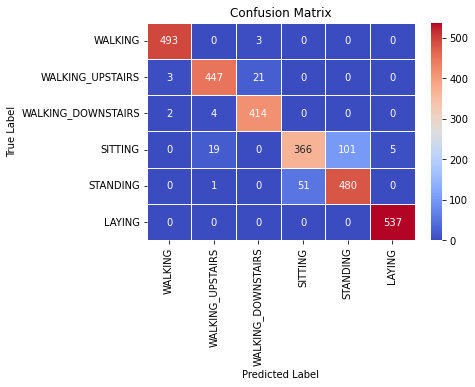

In [19]:
# Maximum validation Accuracy
val_accuracy_tensor = history.history['val_accuracy']
best_val_accuracy = np.max(val_accuracy_tensor)
print("Best Validation Accuracy:", best_val_accuracy)

# confusion matrix
LABELS = ['WALKING',
          'WALKING_UPSTAIRS',
          'WALKING_DOWNSTAIRS',
          'SITTING',
          'STANDING',
          'LAYING']
best_model = load_model("cnn_lstm_weights.h5")
y_pred_test = best_model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

true_classes = np.argmax(Y_test, axis=1)
predicted_classes = np.argmax(y_pred_test, axis=1)
report = classification_report(true_classes, predicted_classes, digits=4)
print("Classification Report:\n", report)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='coolwarm',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
